In [2]:
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D, Rescaling
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras.applications.vgg16 import VGG16
from keras.models import Model
from glob import glob
from tqdm import tqdm
import cv2
from keras import saving

import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd

<h2>Model built in</h2>

In [ ]:
input_shape = (224,224,3) #Input layer shape (the images must have the same shape)
base_model = VGG16(input_shape=input_shape, include_top=False, weights='imagenet') #VGG16 model loading

In [4]:
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
for layer in base_model.layers:
    base_model.trainable = False

<h3>Getting the name of the classes</h3>

In [7]:
class_dirs = glob("C:/Users/LENOVO/Documents/jupyterScripts/AI/Entrainement des fruits/fruits-360-original-size-main/Training"+"/*")
class_names = []
for x in tqdm(class_dirs):
    class_names.append(x.split("\\")[1])
print(class_names)

100%|██████████| 24/24 [00:00<00:00, 55127.76it/s]

['apple_6', 'apple_braeburn_1', 'apple_crimson_snow_1', 'apple_golden_1', 'apple_golden_2', 'apple_golden_3', 'apple_granny_smith_1', 'apple_hit_1', 'apple_pink_lady_1', 'apple_red_1', 'apple_red_2', 'apple_red_3', 'apple_red_delicios_1', 'apple_red_yellow_1', 'apple_rotten_1', 'cabbage_white_1', 'carrot_1', 'cucumber_1', 'cucumber_3', 'eggplant_long_1', 'pear_1', 'pear_3', 'zucchini_1', 'zucchini_dark_1']


<h2>Creating additional layers as output layer</h2>

In [17]:
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
prediction = Dense(len(class_names), activation='softmax')(x)

In [ ]:
model = Model(inputs = base_model.input, outputs = prediction) #Creating the model with the layers of the VGG16 model and additional layers
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 24)             │        12,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,572,568 (105.18 MB)

 Trainable params: 12,857,880 (49.05 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

<h2>Model compilation</h2>

In [19]:
model.compile(
    optimizer= 'adam',
    loss= 'categorical_crossentropy',
    metrics= ['accuracy']
)

<h2>Load and generate additional data</h2>

In [ ]:
# Generator model for training dataset
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    horizontal_flip = True
)

# Generator model for validation dataset
validation_datagen = ImageDataGenerator(rescale=1./255)

# Generate training dataset
train_dataset = train_datagen.flow_from_directory(
    "C:/Users/LENOVO/Documents/jupyterScripts/AI/Entrainement des fruits/fruits-360-original-size-main/Training",
    target_size = (224,224), # Shape of new images to be generated (same as model input layer shape)
    batch_size = 32,
    class_mode = 'categorical'
)

#Generate validation dataset
validation_dataset = validation_datagen.flow_from_directory(
    "C:/Users/LENOVO/Documents/jupyterScripts/AI/Entrainement des fruits/fruits-360-original-size-main/Validation",
    target_size = (224,224), # Shape of new images to be generated (same as model input layer shape)
    batch_size = 32,
    class_mode = 'categorical'
)

Found 6231 images belonging to 24 classes.
Found 3114 images belonging to 24 classes.


<h2>Fit the model with our training dataset</h2>

In [21]:
history = model.fit(
    train_dataset,
    epochs= 10,
    validation_data = validation_dataset
)

Epoch 1/10


c:\Users\LENOVO\anaconda3\envs\DataScience\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


195/195 ━━━━━━━━━━━━━━━━━━━━ 3634s 19s/step - accuracy: 0.3448 - loss: 3.1644 - val_accuracy: 0.8459 - val_loss: 0.5662
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 4552s 23s/step - accuracy: 0.8184 - loss: 0.5935 - val_accuracy: 0.8144 - val_loss: 0.4310
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 3177s 16s/step - accuracy: 0.8831 - loss: 0.3709 - val_accuracy: 0.8818 - val_loss: 0.2896
Epoch 4/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 7571s 39s/step - accuracy: 0.9049 - loss: 0.2949 - val_accuracy: 0.9351 - val_loss: 0.1809
Epoch 5/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2561s 13s/step - accuracy: 0.9415 - loss: 0.1923 - val_accuracy: 0.8815 - val_loss: 0.3495
Epoch 6/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 3475s 18s/step - accuracy: 0.9477 - loss: 0.1667 - val_accuracy: 0.9457 - val_loss: 0.1190
Epoch 7/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 5024s 26s/step - accuracy: 0.9386 - loss: 0.1806 - val_accuracy: 0.9740 - val_loss: 0.0742
Epoch 8/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 16497s 85s/step - accuracy: 0.9547 - loss: 0.1465 - va

<h2>Displaying model accuracy</h2>

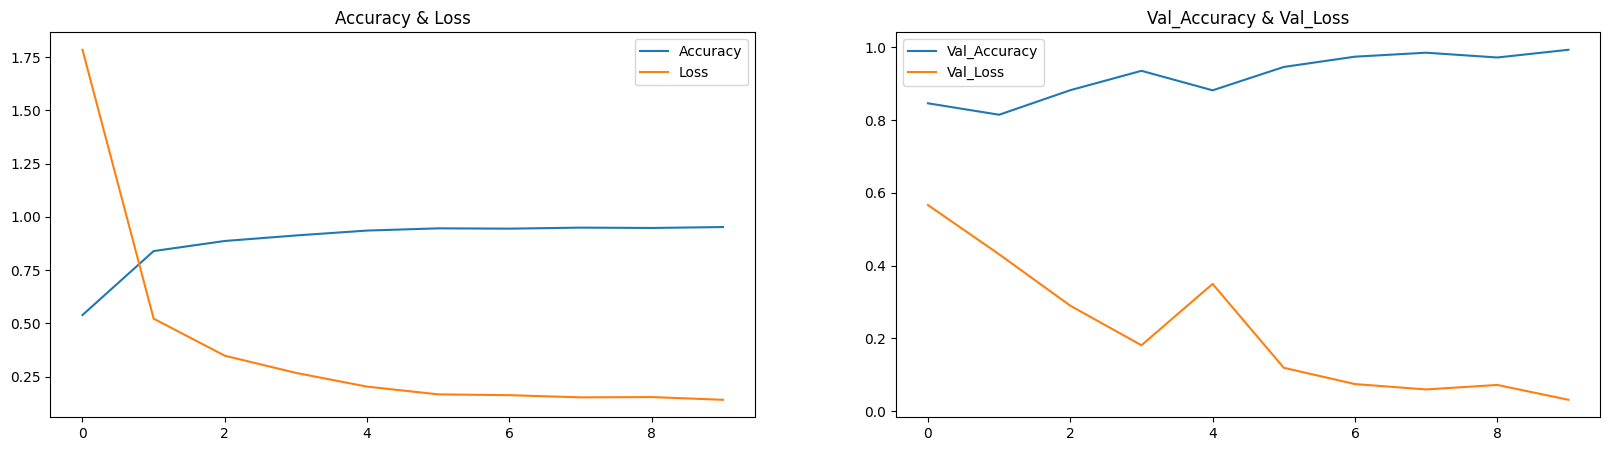

In [65]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['loss'], label='Loss')
plt.legend()
plt.title('Accuracy & Loss')
plt.subplot(1,2,2)
plt.plot(history.history['val_accuracy'], label='Val_Accuracy')
plt.plot(history.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Val_Accuracy & Val_Loss')
plt.show()

In [31]:
model.evaluate(validation_dataset, verbose=1)

c:\Users\LENOVO\anaconda3\envs\DataScience\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


98/98 ━━━━━━━━━━━━━━━━━━━━ 1110s 11s/step - accuracy: 0.9937 - loss: 0.0295


[0.031073972582817078, 0.9929351210594177]

<h2>Model saving<h2>

In [ ]:
model.save('vgg16_retrained.h5') #Saving method 1

In [ ]:
saving.save_model(model, "vgg16_retrained1.keras") #Saving method 2

<h2>Function to prepare and reshape images for model prediction</h2>

In [38]:
def preparation(file_path):
    img = cv2.imread(file_path)
    plt.figure()
    plt.imshow(img)
    plt.show()
    img = cv2.resize(img,(224,224))
    img = img.astype('float32')/255
    img = np.expand_dims(img, axis=0)
    return img